# Subtask 1: Implement parallel computation of the spectrogram
see <i> parallel_spectogram.py </i>
# Subtask 2: Plot speedup vs number of processes

In [4]:
%%writefile parallel_spectogram.py

import numpy as np
import time
from mpi4py import MPI

def WindowFunction(t, window_position, window_width):
    return np.exp(-(t - window_position)**2 / 2 / window_width**2)

def generation_of_signal(t):
    y = np.sin(t) * np.exp(-t**2 / (2 * 20**2))
    y = y + np.sin(3 * t) * np.exp(-(t - 5 * 2*np.pi)**2 / (2 * 20**2))
    y = y + np.sin(5.5 * t) * np.exp(-(t - 10 * 2*np.pi)**2 / (2 * 5**2))
    return y

def get_specgram(y, t, window_positions, windowsteps, window_width):
    specgram = np.zeros((len(t), windowsteps))

    for i in range(windowsteps):
        sp = np.fft.fft(y * WindowFunction(t, window_positions[i], window_width))
        specgram[:, i] = abs(sp)**2

    return specgram

time_start = time.time()

comm = MPI.COMM_WORLD

size = comm.Get_size()
rank = comm.Get_rank()

# Parameters of calculation
nwindowsteps = 1000
window_width = 2.0 * 2 * np.pi
t = np.linspace(-20 * 2*np.pi, 20 * 2*np.pi, 3**9 + 6)
y = generation_of_signal(t)
window_positions = np.linspace(-20 * 2*np.pi, 20 * 2*np.pi, nwindowsteps)

# Ranging calculations between processes
index = np.linspace(0, nwindowsteps, size + 1, dtype = int)
window_pos_rank = window_positions[index[rank]:index[rank + 1]]

# Calculation in every process
spectogram = get_specgram(y, t, window_pos_rank, len(window_pos_rank), window_width)
    
data = comm.gather(spectogram, root = 0)

if rank == 0:
    work_time = time.time() - time_start
    print(work_time)


Writing parallel_spectogram.py


## Parallel computation call and Calculation of speedup

In [11]:
import numpy as np

process = np.arange(1, 16)
calculation_time = []

for i in process:
    
    time = !mpiexec -np {i} python parallel_spectogram.py
    calculation_time.append(float(time[0]))
    print(float(time[0]))
    
speedup = []
    
for i in calculation_time:
    speedup.append(calculation_time[0] / i)

3.844561815261841
2.323578119277954
1.8334174156188965
1.7381088733673096
1.6054332256317139
1.8482904434204102
1.6331441402435303
1.6697876453399658
1.601325511932373
1.745593547821045
1.597093105316162
1.7708559036254883
1.5833687782287598
1.6073226928710938
1.6125977039337158


## Plot of speedup vs number of processes

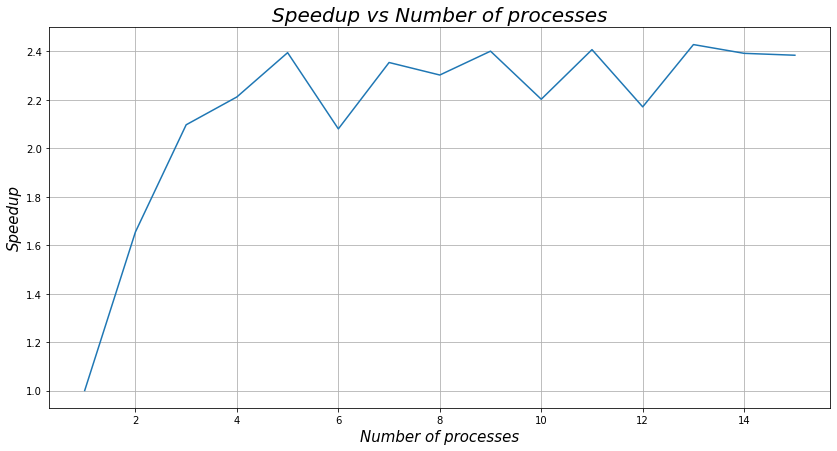

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(process, speedup)
ax.set_title('Speedup vs Number of processes', fontsize = 20, fontstyle = 'oblique')

plt.xlabel('Number of processes', fontsize = 15, fontstyle = 'oblique')
plt.ylabel('Speedup', fontsize = 15, fontstyle = 'oblique')

plt.grid(True)

plt.show()